#  **Unsupervised_Learning_Project: Team JB3**

### **Building an Anime Recommendation System**

<div align="center" style="font-size: 40%; text-align: center; margin: 0 auto">
    <img src="https://mcdn.wallpapersafari.com/medium/67/98/JKSuGa.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 800px; height: 200px;" />
</div>


# **Project Overview**

## **Introduction**

Anime has become a global phenomenon, captivating audiences with its unique storytelling, diverse genres, and vibrant characters. With an ever-growing collection of anime titles available, it can be challenging for viewers to discover new series that align with their tastes.
- This project aims to solve this problem by developing a robust anime recommendation system that leverages both collaborative filtering and content-based filtering techniques to accurately predict how a user will rate an anime title they have not yet viewed.

## **Objective**

The primary objective of this project is to create an end-to-end recommendation system capable of providing personalized anime recommendations to users. This involves:

- **Data Loading and Preprocessing**: Cleaning and preparing the datasets for analysis.
- **Collaborative Filtering Model**: Using user ratings to recommend anime titles.
- **Content-Based Filtering Model**: Utilizing anime metadata to find similar titles.
- **Hybrid Recommender System**: Combining collaborative and content-based models for enhanced accuracy.
- **Model Evaluation**: Assessing the performance of the models using relevant metrics.
- **Deployment**: Deploying the recommendation system as a web application for easy user access.

## **Loading Packages**

In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings

# **Data Loading**

**Data Sources**

The project uses three primary datasets:

- **anime.csv**: Contains information about anime titles, including genres, type, number of episodes, average rating, and number of members.
- **train.csv**:This file contains rating data, supplied by individual users for individual anime titles. It contains user_id information, the anime_id of the title watched, and the rating given (if applicable).
- **test.csv**: This file will be used to create the final submission. It contains a user_id and an anime_id column only - no rating (that's your task!). These ids will be used to create the rating predictions.

In [2]:
anime_df = pd.read_csv('anime-recommender-system-project-2024/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
test_df= pd.read_csv('anime-recommender-system-project-2024/test.csv')
test_df.head()

,user_id,anime_id
0,40763,21405
1,68791,10504
2,40487,1281
3,55290,165
4,72323,11111


In [4]:
train_df =pd.read_csv('anime-recommender-system-project-2024/train.csv')
train_df.head()

,user_id,anime_id,rating
0,1,11617,10
1,1,11757,10
2,1,15451,10
3,2,11771,10
4,3,20,8


# **Data Cleaning**

Data cleaning is a critical process that underpins the success of any data analysis or machine learning project. By improving data quality, enhancing model performance, reducing bias and overfitting, facilitating effective unsupervised learning, increasing data usability, saving time and resources, and enhancing trust and credibility, data cleaning ensures that the insights derived from data are accurate, reliable, and actionable.

In [5]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


- There are 12294 entries, indicating the dataset covers a significant number of anime series.
- anime_id, name, episodes, and members columns have no missing values.
- genre, type, and rating columns have some missing values.
- genre has 62 missing values.
- type has 25 missing values.
- rating has 230 missing values.

- The episodes column is an object type, which suggests it may contain non-numeric values (e.g., 'Unknown') or requires conversion to numeric type.

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633686 entries, 0 to 633685
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   633686 non-null  int64
 1   anime_id  633686 non-null  int64
dtypes: int64(2)
memory usage: 9.7 MB


- There are 633686 entries, indicating a large dataset of user-anime interactions.
- No missing values are present in this DataFrame.

- Both columns (user_id and anime_id) are integer types, which is appropriate for identifiers.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703554 entries, 0 to 5703553
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 130.5 MB


- There are 5703554 entries, which is significantly larger than the test set, suggesting a comprehensive training dataset.
- No missing values are present in this DataFrame.

- All columns are integer types, which is appropriate for identifiers and ratings.

## **Handling Missing Values, Removing Duplicates and Type Convertion**

For **`anime_df`:**

- **`genre`**, **`type`**, and **`rating`** columns have missing values. we handle these missing values by:

- Imputing with the most frequent value, mean, or a specific placeholder.

- Dropping rows with missing values if they are not significant in number.

**Data Types**

The **`episodes`** column in **`anime_df`** should be checked for non-numeric values and converted to integers if possible.

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data (replace 'your_file.csv' with the actual file paths)
anime_df = pd.read_csv('anime-recommender-system-project-2024/anime.csv')
test_df = pd.read_csv('anime-recommender-system-project-2024/test.csv')
train_df = pd.read_csv('anime-recommender-system-project-2024/train.csv')

# Clean anime_df
anime_df.drop_duplicates(inplace=True)
anime_df['genre'].fillna('Unknown', inplace=True)
anime_df['type'].fillna('Unknown', inplace=True)
anime_df['rating'].fillna(anime_df['rating'].mean(), inplace=True)
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce').fillna(0).astype(int)

# Clean test_df
test_df.drop_duplicates(inplace=True)

# Clean train_df
train_df.drop_duplicates(inplace=True)
train_df['rating'].fillna(train_df['rating'].mean(), inplace=True)

# Check the cleaned data
print(anime_df.info())
print(test_df.info())
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  int64  
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 672.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633686 entries, 0 to 633685
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   633686 non-null  int64
 1   anime_id  633686 non-null  int64
dtypes: int64(2)
memory usage: 9.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 5703553 entries, 0 to 5703553
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int


- **Removing Duplicates**: Ensures that each record in the dataset is unique, preventing redundant or misleading data points from skewing the analysis.

- **Handling Missing Values**: Fills missing values with appropriate substitutes to maintain data integrity. Missing genres and types are filled with 'Unknown', missing ratings are filled with the mean rating, and non-numeric episodes are coerced to 0.

- **Type Conversion**: Converts the episodes column to numeric values, treating non-numeric entries as 0 to ensure consistent data types.

- These steps will help ensure that the datasets are clean, reducing the risk of errors or biases in subsequent analysis or modeling tasks.

**1. Key Insights for anime_df**
- **Complete Data:** No missing values across all columns, which simplifies preprocessing.

- **Data Types:**
- **Numeric columns**  (anime_id, episodes, rating, members) are correctly typed for analysis.

- **Categorical columns** (name, genre, type) are strings, which may require encoding for certain types of analysis.

- **Memory Efficiency**: The DataFrame uses a moderate amount of memory (672.5 KB).

**2. Key Insights for test_df**


- **Complete Data**: No missing values across both columns.

- **Data Types:**
Both columns are correctly typed as integers, suitable for analysis and modeling.

- **Memory Efficiency**: The DataFrame uses a moderate amount of memory (9.7 MB), considering its size.

**3. Key Insights for train_df**

- **Complete Data:** No missing values across all columns.

- **Data Types:**
All columns are correctly typed as integers, which is suitable for analysis and modeling.

- **Memory Usage**: The DataFrame uses a significant amount of memory (174.1 MB) due to its large size.

## **Convert Categorical Variables**

In [9]:
anime_df = pd.get_dummies(anime_df, columns=['genre', 'type'], drop_first=True)


## **Outlier Detection and Removal**

In [10]:
from scipy import stats
import numpy as np

def remove_outliers_zscore(df, column_name):
    z_scores = np.abs(stats.zscore(df[column_name]))
    df = df[(z_scores < 3)]
    return df

# Apply to anime_df for 'rating' and 'members'
anime_df = remove_outliers_zscore(anime_df, 'rating')
anime_df = remove_outliers_zscore(anime_df, 'members')

# Apply to train_df for 'rating'
train_df = remove_outliers_zscore(train_df, 'rating')


**Data Integrity**

Ensure the integrity and consistency of the user-anime interactions by cross-referencing **`anime_id`** in **`test_df`**and **`train_df`** with `anime_df` to confirm that all referenced anime exist in **`anime_df`**.

In [11]:
# Cross-referencing anime_id
valid_anime_ids = set(anime_df['anime_id'])
test_df = test_df[test_df['anime_id'].isin(valid_anime_ids)]
train_df = train_df[train_df['anime_id'].isin(valid_anime_ids)]


In [12]:
print(anime_df.describe())
print(anime_df.info())

print(train_df.describe())
print(train_df.info())


           anime_id      episodes        rating        members
count  11965.000000  11965.000000  11965.000000   11965.000000
mean   14034.817802     11.789553      6.460452   11803.930631
std    11452.410768     46.391173      0.964119   26371.582656
min        5.000000      0.000000      3.430000       5.000000
25%     3482.000000      1.000000      5.900000     221.000000
50%    10210.000000      2.000000      6.530000    1470.000000
75%    24785.000000     12.000000      7.130000    8228.000000
max    34527.000000   1818.000000      9.500000  182713.000000
<class 'pandas.core.frame.DataFrame'>
Index: 11965 entries, 2 to 12293
Columns: 3275 entries, anime_id to type_Unknown
dtypes: bool(3270), float64(1), int64(3), object(1)
memory usage: 37.9+ MB
None
            user_id      anime_id        rating
count  3.590690e+06  3.590690e+06  3.590690e+06
mean   3.698577e+04  8.586914e+03  7.652673e+00
std    2.093476e+04  8.855707e+03  1.453376e+00
min    3.000000e+00  5.000000e+00  4.00000

# **Exploratory Data Analysis**

Train DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703554 entries, 0 to 5703553
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 130.5 MB
None
            user_id      anime_id        rating
count  5.703554e+06  5.703554e+06  5.703554e+06
mean   3.674460e+04  8.902143e+03  7.808691e+00
std    2.101174e+04  8.882175e+03  1.572449e+00
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.898500e+04  1.239000e+03  7.000000e+00
50%    3.680200e+04  6.213000e+03  8.000000e+00
75%    5.487300e+04  1.407500e+04  9.000000e+00
max    7.351600e+04  3.447500e+04  1.000000e+01

Test DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633686 entries, 0 to 633685
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   633686 non-null  int64
 1   anime_id  633686 non-null  int64
dt

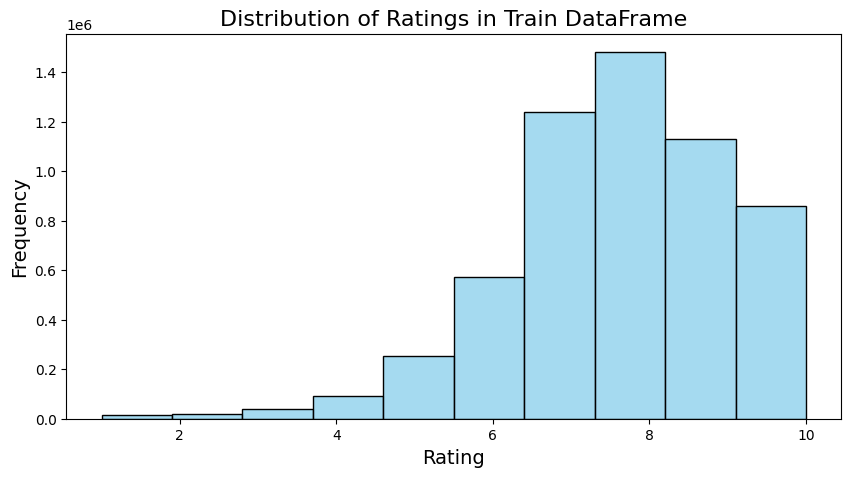

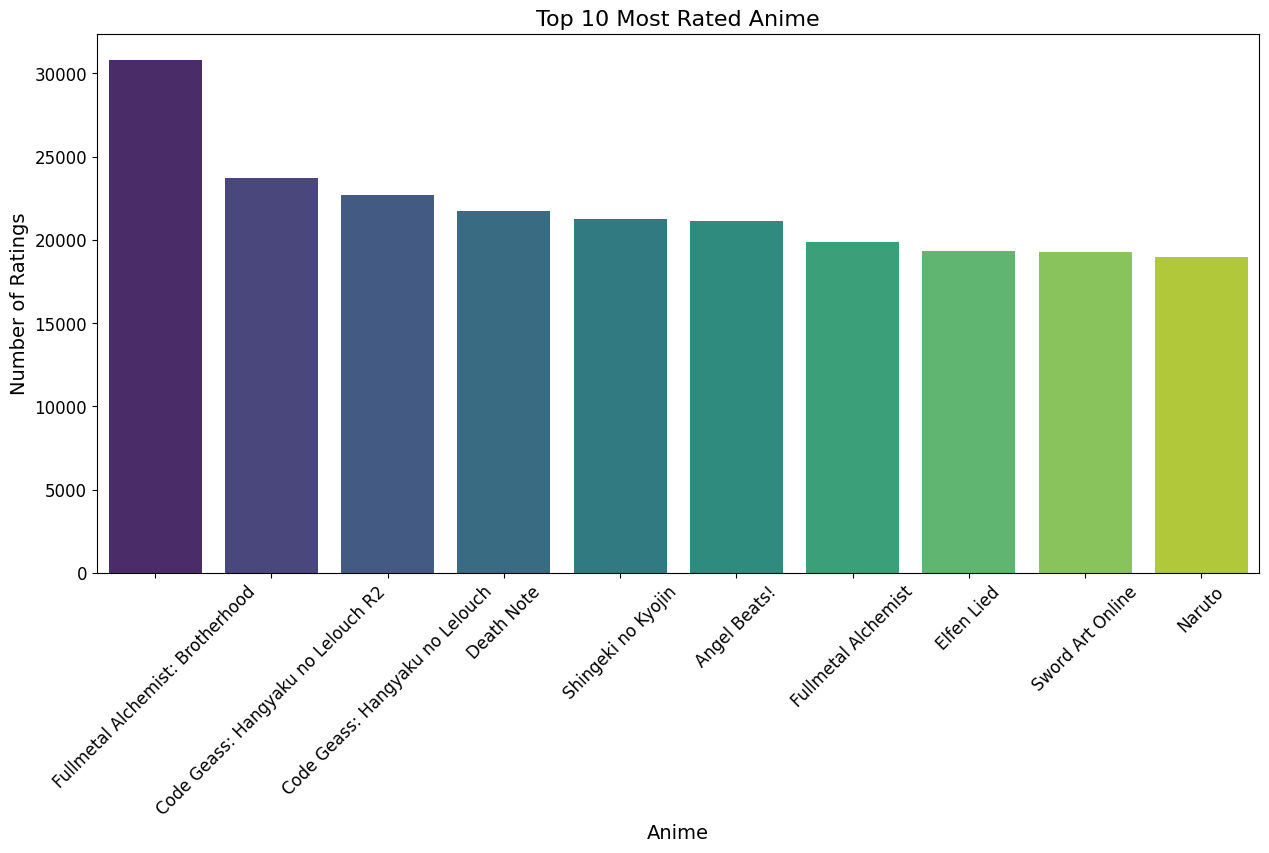

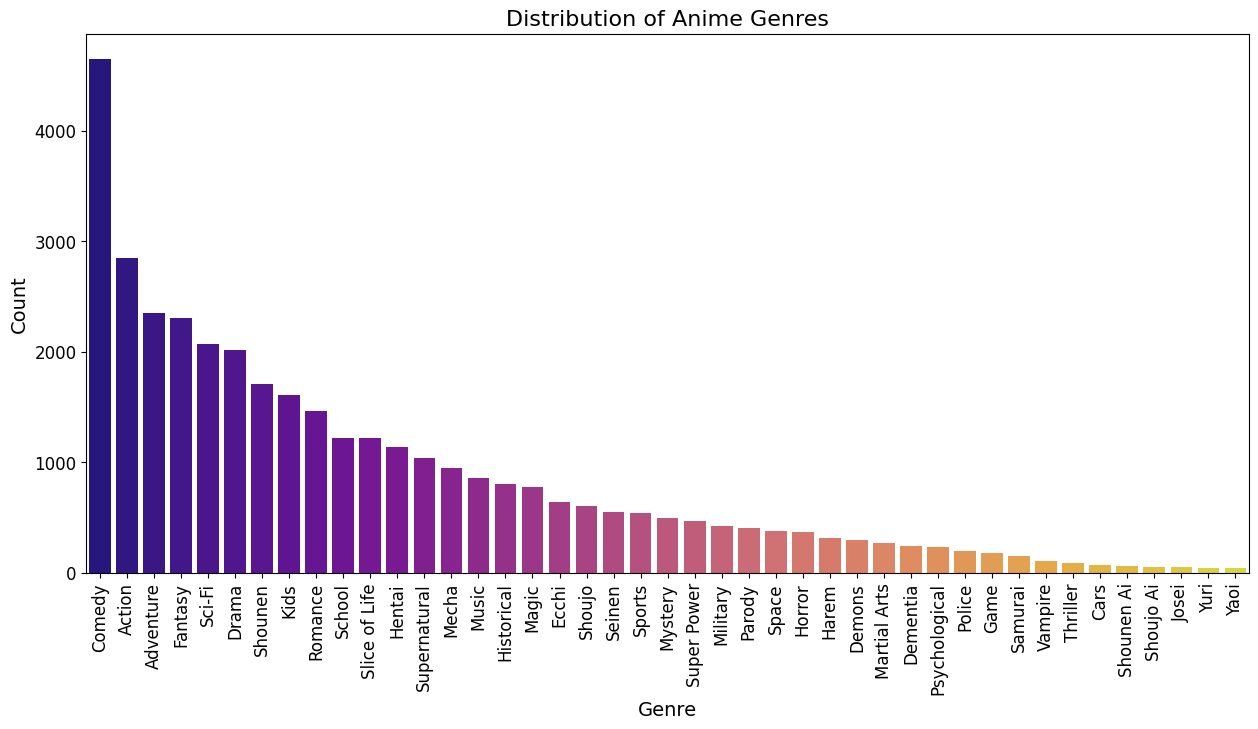

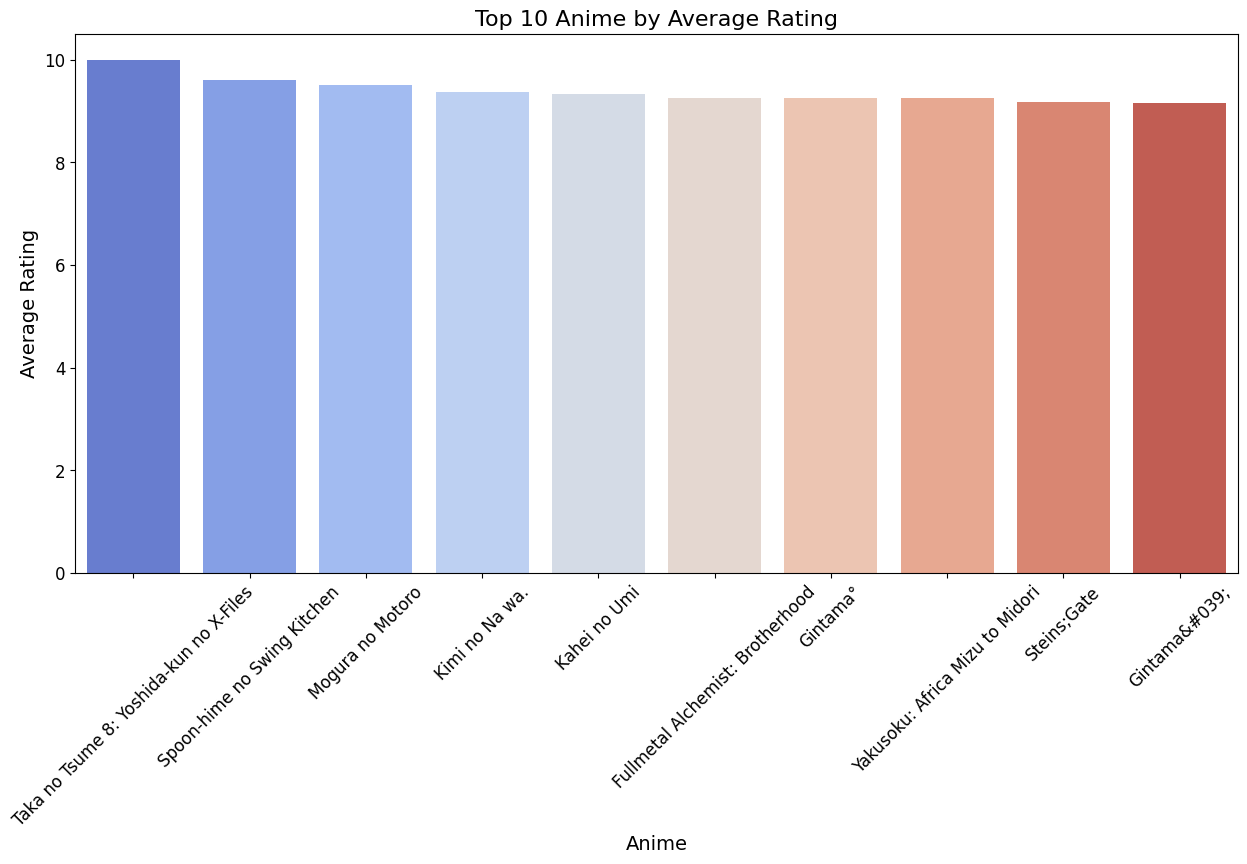

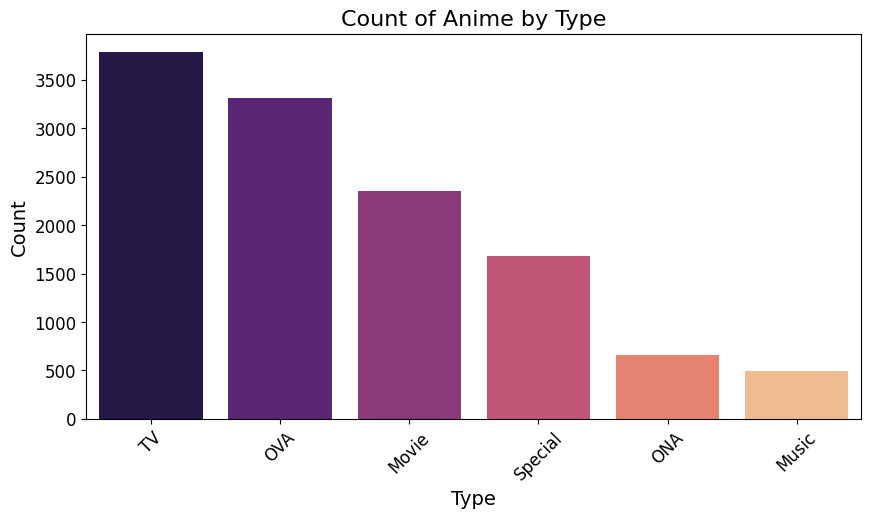

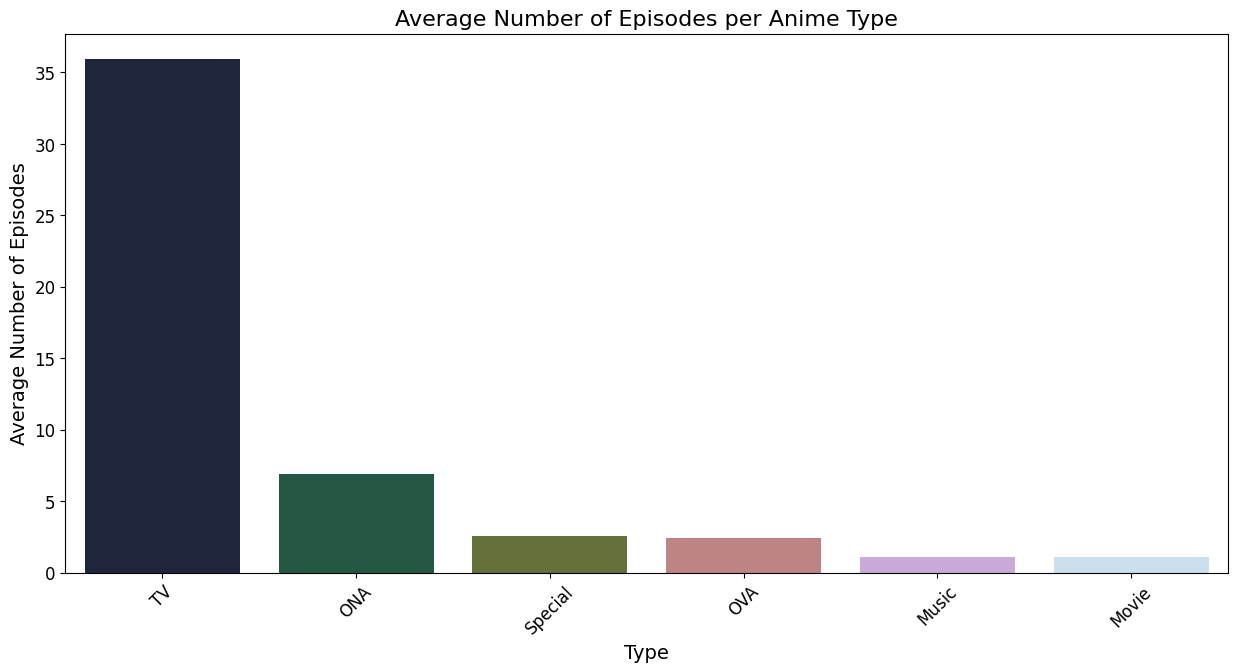

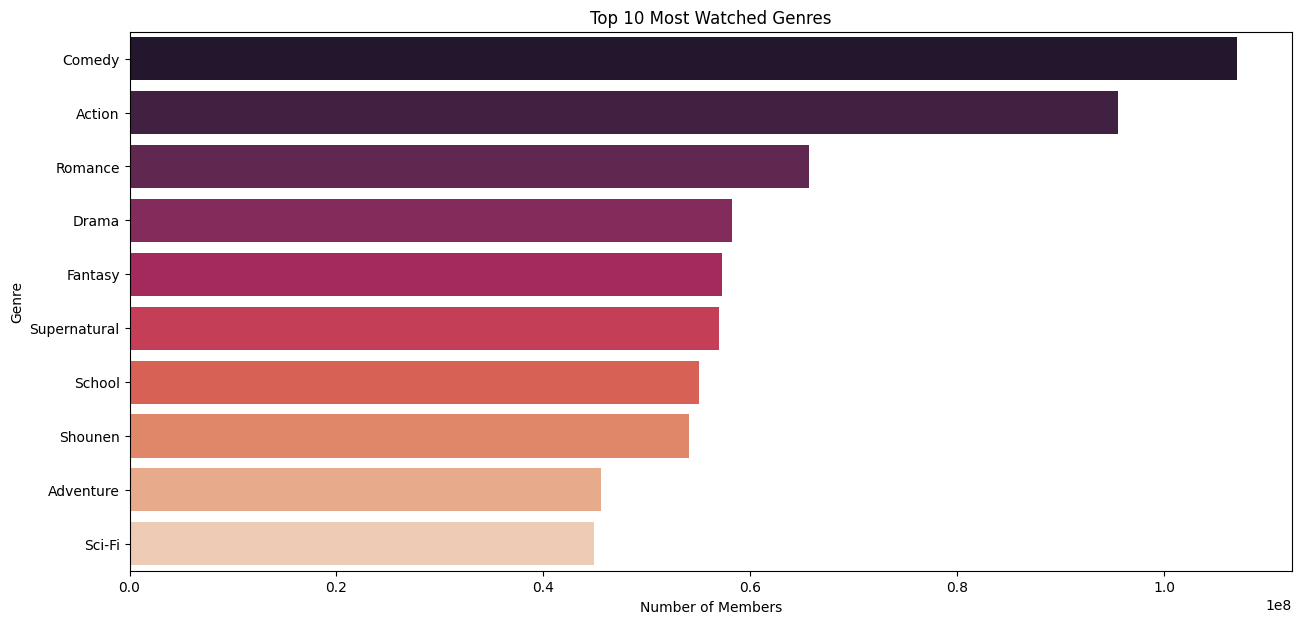

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataframes
train_df = pd.read_csv('anime-recommender-system-project-2024/train.csv')
test_df = pd.read_csv('anime-recommender-system-project-2024/test.csv')
anime_df = pd.read_csv('anime-recommender-system-project-2024/anime.csv')

# Display basic information and statistics
print("Train DataFrame Info")
print(train_df.info())
print(train_df.describe())

print("\nTest DataFrame Info")
print(test_df.info())
print(test_df.describe())

print("\nAnime DataFrame Info")
print(anime_df.info())
print(anime_df.describe())

# Distribution of ratings in train_df
plt.figure(figsize=(10, 5))
sns.histplot(train_df['rating'], bins=10, kde=False, color='skyblue')
plt.title('Distribution of Ratings in Train DataFrame', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Top 10 most rated anime in train_df
top_rated_anime = train_df['anime_id'].value_counts().head(10)
top_rated_anime_names = anime_df[anime_df['anime_id'].isin(top_rated_anime.index)]['name']

plt.figure(figsize=(15, 7))
sns.barplot(x=top_rated_anime_names, y=top_rated_anime.values, palette='viridis')
plt.title('Top 10 Most Rated Anime', fontsize=16)
plt.xlabel('Anime', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Distribution of anime genres
plt.figure(figsize=(15, 7))
anime_genres = anime_df['genre'].dropna().str.split(', ', expand=True).stack().value_counts()
sns.barplot(x=anime_genres.index, y=anime_genres.values, palette='plasma')
plt.title('Distribution of Anime Genres', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Average rating of anime
plt.figure(figsize=(15, 7))
average_anime_rating = anime_df[['name', 'rating']].dropna().sort_values(by='rating', ascending=False).head(10)
sns.barplot(x=average_anime_rating['name'], y=average_anime_rating['rating'], palette='coolwarm')
plt.title('Top 10 Anime by Average Rating', fontsize=16)
plt.xlabel('Anime', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Count of anime by type
plt.figure(figsize=(10, 5))
anime_type_count = anime_df['type'].value_counts()
sns.barplot(x=anime_type_count.index, y=anime_type_count.values, palette='magma')
plt.title('Count of Anime by Type', fontsize=16)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Average number of episodes per anime type
plt.figure(figsize=(15, 7))
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')  # Convert episodes to numeric, coerce errors
average_episodes = anime_df.groupby('type')['episodes'].mean().dropna().sort_values(ascending=False)
sns.barplot(x=average_episodes.index, y=average_episodes.values, palette='cubehelix')
plt.title('Average Number of Episodes per Anime Type', fontsize=16)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Average Number of Episodes', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Split the genres into separate rows
genres_df = anime_df[['genre', 'members']].dropna()
genres_df = genres_df.assign(genre=genres_df['genre'].str.split(', '))
genres_df = genres_df.explode('genre')

# Aggregate the members count by genre
genre_watch_count = genres_df.groupby('genre')['members'].sum().reset_index()

# Sort the genres by the number of members in descending order
genre_watch_count = genre_watch_count.sort_values(by='members', ascending=False)

# Plot the top 10 most watched genres
plt.figure(figsize=(15, 7))
sns.barplot(x='members', y='genre', data=genre_watch_count.head(10), palette='rocket')
plt.title('Top 10 Most Watched Genres')
plt.xlabel('Number of Members')
plt.ylabel('Genre')
plt.show()

# **Data Visualization**
1. **Distribution of Ratings in train_df:**

- Plots a histogram showing the distribution of ratings using sns.histplot.
- Customizes the plot with sky blue color and adds titles and labels.

2. **Top 10 Most Rated Anime:**

- Identifies the top 10 most rated anime in train_df using value counts on anime_id.
- Maps these IDs to their names from anime_df.
- Plots a bar chart using sns.barplot with the anime names and their rating counts, using the viridis color palette.
- Customizes the plot with titles, labels, and rotates x-axis labels for better readability.

3. **Distribution of Anime Genres:**

- Splits the genre column values by commas and stacks them to count occurrences of each genre.
- Plots a bar chart using sns.barplot with the genre counts, using the plasma color palette.
- Customizes the plot with titles, labels, and rotates x-axis labels for better readability.

4. **Top 10 Anime by Average Rating:**

- Identifies the top 10 anime by average rating in anime_df.
- Plots a bar chart using sns.barplot with the anime names and their average ratings, using the coolwarm color palette.
- Customizes the plot with titles, labels, and rotates x-axis labels for better readability.

5. **Count of Anime by Type:**

- Counts the occurrences of each anime type in anime_df.
- Plots a bar chart using sns.barplot with the counts, using the magma color palette.
- Customizes the plot with titles, labels, and rotates x-axis labels for better readability.

6. **Average Number of Episodes per Anime Type:**

- Converts the episodes column to numeric, coercing errors.
- Calculates the average number of episodes per anime type.
- Plots a bar chart using sns.barplot with the average episodes, using the cubehelix color palette.
- Customizes the plot with titles, labels, and rotates x-axis labels for better readability.

7. **Top 10 Most Watched Genres:**

- Data Transformation: Splits multi-genre entries into separate rows to facilitate accurate aggregation.
- Aggregation: Sums the number of members for each genre to determine popularity.
- Sorting: Orders the genres based on the number of members in descending order to identify the most popular genres.

- Visualization: Creates a bar plot with a visually appealing color palette, focusing on the top 10 most popular genres by the number of members.

# **Correlation Heatmap**

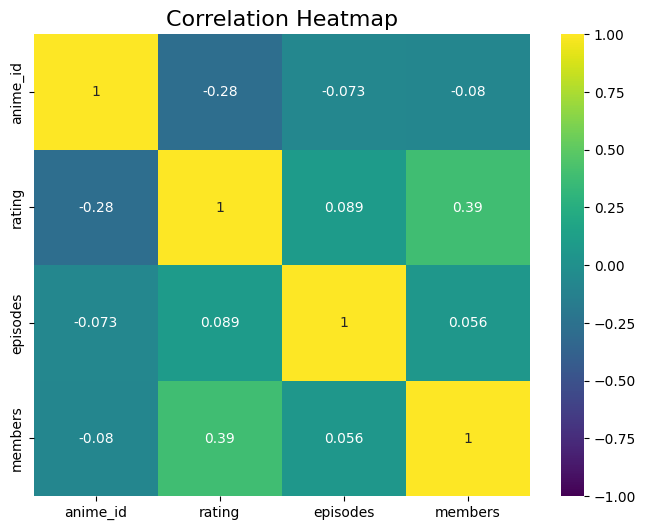

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you want to use the 'anime_df' DataFrame for correlation, as it contains 'episodes' and 'members'
numeric_df = anime_df[['anime_id', 'rating', 'episodes', 'members']]  # Select columns from anime_df

# Replace "Unknown" in 'episodes' with NaN for correlation calculation
numeric_df['episodes'].replace('Unknown', pd.NA, inplace=True)

# Convert 'episodes' to numeric, coercing errors to NaN
numeric_df['episodes'] = pd.to_numeric(numeric_df['episodes'], errors='coerce')

# Correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

- Data Selection: Focuses on specific numeric columns relevant to the analysis.
- Handling Non-Numeric Data: Ensures the episodes column is properly converted to numeric by handling "Unknown" values and coercing errors.
- Correlation Analysis: Provides insights into the relationships between anime_id, rating, episodes, and members.

- Heatmap Visualization: Uses a heatmap to visually represent the correlation matrix, making it easy to identify strong or weak correlations between variables.

# **Unsupervised Learning Models**

- Unsupervised learning models are a type of machine learning algorithm used to draw inferences from datasets without labeled responses.
- Unsupervised learning models can be quite useful in analyzing and extracting meaningful patterns from your anime dataset, especially in the context of your recommender system project
- These models find hidden patterns or intrinsic structures in the data.

***Loading Packages***

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
anime_df = pd.read_csv('anime_cleaned.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [17]:
train_df = pd.read_csv('train_cleaned.csv')
train_df.head()

,user_id,anime_id,rating
0,1,11617.0,10.0
1,1,11757.0,10.0
2,1,15451.0,10.0
3,2,11771.0,10.0
4,3,20.0,8.0


**Feature Extraction**

***Principal Component Analysis***

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction.
- It transforms a dataset with potentially correlated variables into a set of linearly uncorrelated variables called principal components.

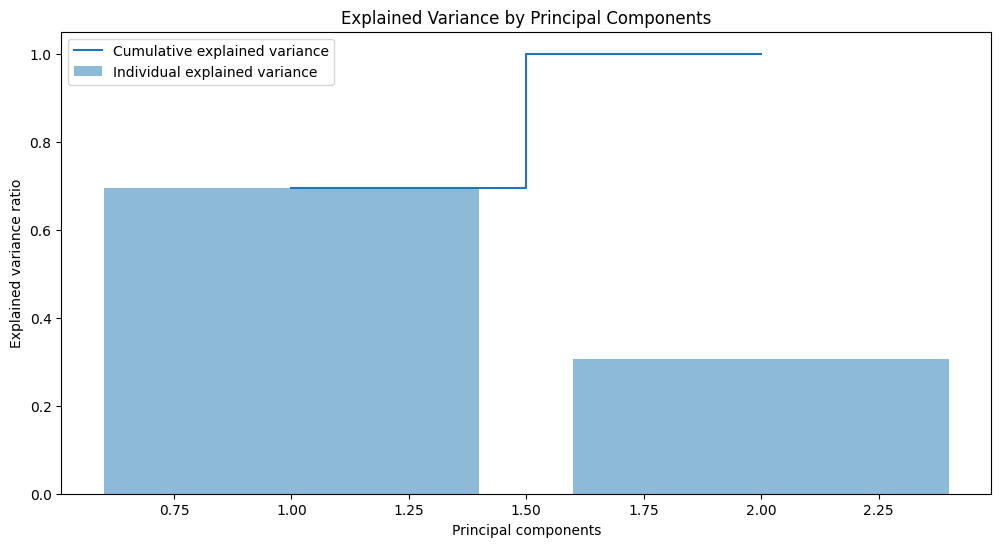

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Assuming anime_df is already loaded

# Select numerical columns for PCA
pca_data = anime_df[['rating', 'members']].dropna()

# Standardize the data
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=None)  # None means we keep all components
principal_components = pca.fit_transform(pca_data_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance and cumulative variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()



**Analysis**

Explained variance by principal components is a crucial concept when performing Principal Component Analysis (PCA).
- It helps in understanding how much information (variance) is captured by each principal component in the dataset.
- The principal components are ordered by the amount of variance they explain in the data. The first principal component explains the most variance, the second explains the second most, and so on.
- The total variance explained by all components is equal to the sum of their individual variances.

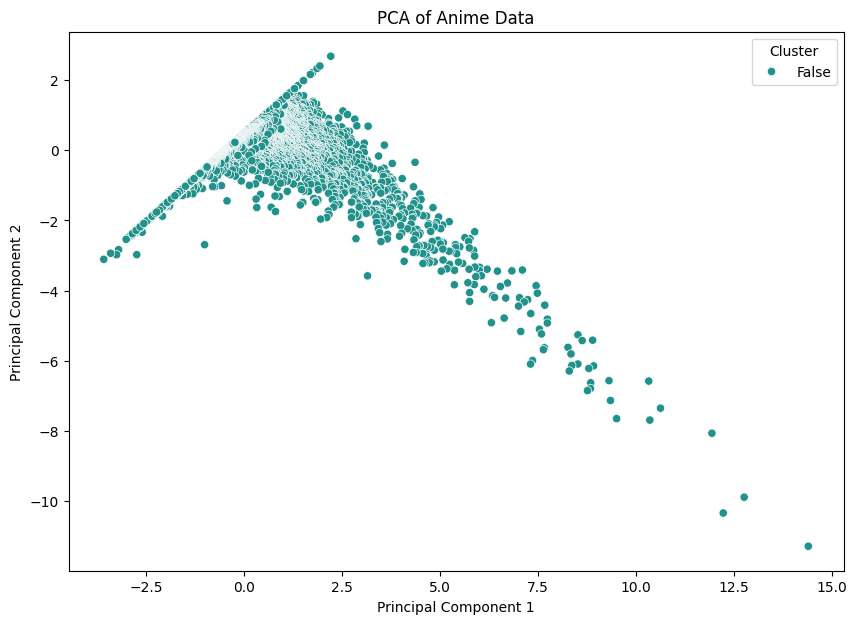

Loadings (coefficients of the original features in the principal components):
              PC1       PC2
rating   0.707107  0.707107
members  0.707107 -0.707107


In [19]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Add the cluster labels to the PCA DataFrame if clustering was performed
if 'cluster' in anime_df.columns:
    pca_df['cluster'] = anime_df.loc[pca_df.index, 'cluster']

# Visualize the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue=False, palette='viridis', data=pca_df)
plt.title('PCA of Anime Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Loadings (coefficients of the original features in the principal components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])], index=['rating', 'members'])
print("Loadings (coefficients of the original features in the principal components):")
print(loadings)

**Analysis**

- Variance Explained: PC1 explains a large portion of the variance, indicating that a significant amount of information in the dataset can be captured by this single component. PC2 adds additional explanatory power.
- Feature Contributions: The loadings indicate the relative importance of the original features in each principal component. Understanding these contributions helps interpret the principal components in terms of the original features.
- Clusters Visualization: The scatter plot of the principal components can reveal patterns and separations that may correspond to underlying clusters in the data.

### **Model Training**

***Clustering Models***

Clustering models are unsupervised learning algorithms used to group similar items together in a dataset.
- They are valuable for exploratory data analysis, pattern recognition, and segmentation tasks

**K-Means Clustering**

Divides the dataset into K clusters by minimizing the variance within each cluster.
- Requires specifying the number of clusters K beforehand.
- Effective for large datasets and when clusters are well-separated.

In [20]:
# Load the CSV files
anime_cleaned = pd.read_csv('anime_cleaned.csv')
train_cleaned = pd.read_csv('train_cleaned.csv')

# Display the first few rows of each dataframe to understand their structure
anime_cleaned_head = anime_cleaned.head()
train_cleaned_head = train_cleaned.head()

anime_cleaned_head, train_cleaned_head


# Merge the two dataframes on the 'anime_id' column
merged_df = pd.merge(train_cleaned, anime_cleaned, on='anime_id')

# Display the first few rows of the merged dataframe
merged_df_head = merged_df.head()

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_anime_ratings.csv', index=False)

merged_df_head


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,11617.0,10.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,7.70,398660
1,1,11757.0,10.0,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25.0,7.83,893100
2,1,15451.0,10.0,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12.0,7.87,266657
3,2,11771.0,10.0,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25.0,8.46,338315
4,3,20.0,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297


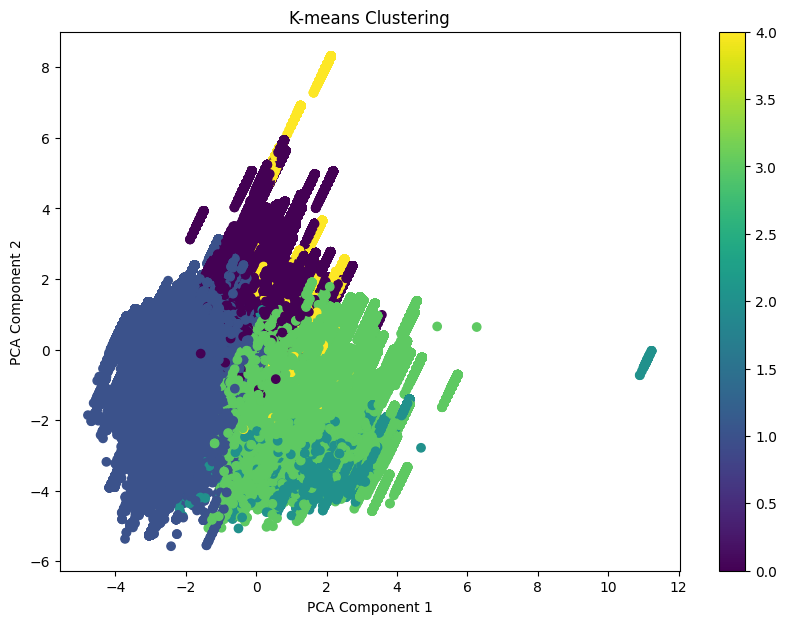

RMSE for K-means Clustering: 0.9616449301898391
                  name  cluster
0      High School DxD        1
1     Sword Art Online        3
2  High School DxD New        3
3     Kuroko no Basket        1
4               Naruto        3


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
anime_ratings = pd.read_csv('merged_anime_ratings.csv')

# Preprocess the data
anime_ratings['episodes'] = anime_ratings['episodes'].fillna(anime_ratings['episodes'].median())

# One-hot encode 'genre' and 'type' columns if they exist
if 'genre' in anime_ratings.columns:
    def encode_genres(df, column):
        genres_encoded = df[column].str.get_dummies(sep=',')
        return genres_encoded

    anime_ratings = pd.concat([anime_ratings.drop(columns=['genre']), encode_genres(anime_ratings, 'genre')], axis=1)

if 'type' in anime_ratings.columns:
    anime_ratings = pd.get_dummies(anime_ratings, columns=['type'])

# Assuming 'name' is the identifier and should not be scaled
X = anime_ratings.drop(columns=['name'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions with PCA (optional)
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
anime_ratings['cluster'] = kmeans.fit_predict(X_scaled)

# Plot the clusters (using PCA components)
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anime_ratings['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Calculate RMSE for K-means Clustering
def calculate_rmse(data, labels, centroids):
    distances = np.sqrt(((data - centroids[labels]) ** 2).sum(axis=1))
    rmse = np.sqrt(mean_squared_error(data, centroids[labels]))
    return rmse

# Get centroids from K-means
centroids = kmeans.cluster_centers_

# Calculate RMSE
rmse_kmeans = calculate_rmse(X_scaled, anime_ratings['cluster'], centroids)
print(f'RMSE for K-means Clustering: {rmse_kmeans}')

# Display cluster assignments
print(anime_ratings[['name', 'cluster']].head())


**Elbow Method**

The Elbow Method plot helps determine the optimal number of clusters by looking for the "elbow point" where the SSE (Sum of Squared Errors) starts to flatten.

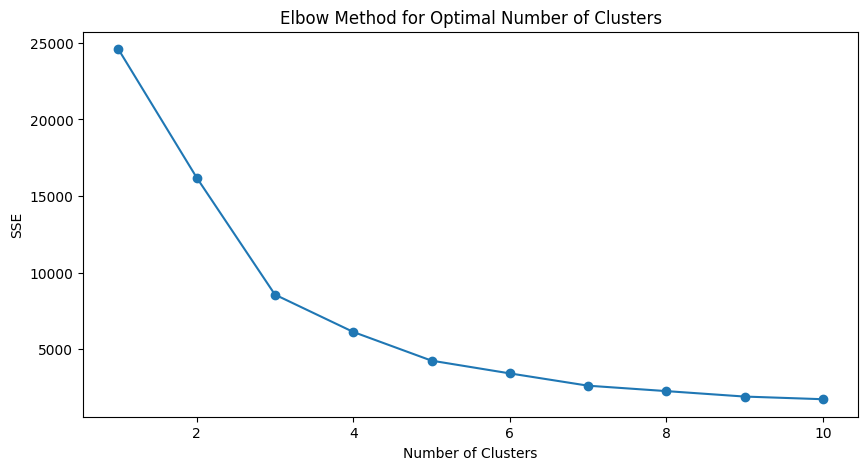

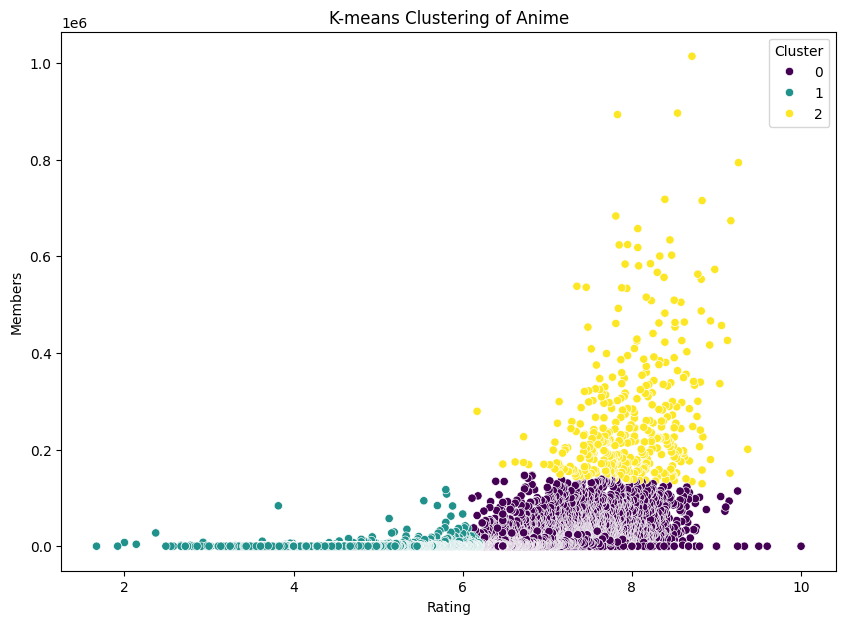

           rating        members
cluster                         
0        7.007000   15212.382560
1        5.376371    1240.570419
2        7.990356  266468.561170


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming anime_df is already loaded

# Select numerical columns for clustering
# Instead of dropping NaN values, fill them with a suitable strategy
# For this example, we will fill missing rating with the mean rating and
# missing members with 0 (assuming no members means it's not popular)
cluster_data = anime_df[['rating', 'members']].fillna({'rating': anime_df['rating'].mean(), 'members': 0})

# Standardize the data
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Determine the number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Fit K-means with the optimal number of clusters (e.g., 3 clusters)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Predict clusters for the entire dataset (including rows with missing values)
anime_df['cluster'] = kmeans.fit_predict(cluster_data_scaled) # Use the filled data for clustering

# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='rating', y='members', hue='cluster', palette='viridis', data=anime_df)
plt.title('K-means Clustering of Anime')
plt.xlabel('Rating')
plt.ylabel('Members')
plt.legend(title='Cluster')
plt.show()

# Display the mean values for each cluster
cluster_means = anime_df.groupby('cluster')[['rating', 'members']].mean()
print(cluster_means)

**Analysis**

- The Elbow Method plot helps determine the optimal number of clusters by looking for the "elbow point" where the SSE (Sum of Squared Errors) starts to flatten.
- From the plot, we can see that the anime are grouped, which helps in understanding the distribution and relationship between rating and popularity (members).
- The scatter plot visualization helps in understanding how the clusters are distributed based on rating and members. Each point represents an anime, and the color indicates the cluster it belongs to.

**Hierarchical Clustering**

Hierarchical clustering is a powerful technique used to group similar items into clusters hierarchically.
- It's particularly useful for exploratory data analysis and can help in understanding relationships between anime titles based on their attributes

In [23]:
from sklearn.preprocessing import StandardScaler

# Handle missing values: Fill NaNs in 'rating_x' and 'rating_y' with the mean of their respective columns
merged_df['rating_x'].fillna(merged_df['rating_x'].mean(), inplace=True)
merged_df['rating_y'].fillna(merged_df['rating_y'].mean(), inplace=True)

# Scaling features: Standardize the numerical features 'rating_x' and 'rating_y'
scaler = StandardScaler()
merged_df[['rating_x', 'rating_y']] = scaler.fit_transform(merged_df[['rating_x', 'rating_y']])

# Display the first few rows of the preprocessed dataframe
merged_df.head()


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,11617.0,1.396838,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12.0,0.034596,398660
1,1,11757.0,1.396838,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25.0,0.227601,893100
2,1,15451.0,1.396838,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12.0,0.286988,266657
3,2,11771.0,1.396838,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25.0,1.162935,338315
4,3,20.0,0.131207,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,0.197908,683297


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the merged dataset
merged_df = pd.read_csv('merged_anime_ratings.csv')

# Fill NaNs in 'rating_x' and 'rating_y' with the mean of their respective columns
merged_df['rating_x'].fillna(merged_df['rating_x'].mean(), inplace=True)
merged_df['rating_y'].fillna(merged_df['rating_y'].mean(), inplace=True)


In [25]:

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv('merged_anime_ratings.csv')

# Select only the numeric columns for scaling
numeric_columns = data.select_dtypes(include=['number']).columns
data_numeric = data[numeric_columns]

# Standardize the numeric data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# If you want to keep it as a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=numeric_columns)

print(data_scaled.head())


    user_id  anime_id  rating_x  episodes  rating_y   members
0 -1.768937  0.277572  1.396838 -0.193275  0.034596  1.097936
1 -1.768937  0.292976  1.396838  0.173396  0.227601  3.659004
2 -1.768937  0.699421  1.396838 -0.193275  0.286988  0.414195
3 -1.768707  0.294517  1.396838  0.173396  1.162935  0.785365
4 -1.768476 -0.998428  0.131207  5.673447  0.197908  2.572280


In [26]:
import pandas as pd

# Load the data
anime_ratings = pd.read_csv('merged_anime_ratings.csv')

# Handling missing values: Fill missing values in 'episodes' column with the median value
anime_ratings['episodes'] = anime_ratings['episodes'].fillna(anime_ratings['episodes'].median())

# Encoding categorical variables: Using one-hot encoding for 'genre' and 'type' columns
anime_ratings = pd.get_dummies(anime_ratings, columns=['genre', 'type'])

# Now you can proceed with other preprocessing steps or model training


In [27]:
from sklearn.preprocessing import LabelEncoder

# Load the dataset again
anime_ratings = pd.read_csv('merged_anime_ratings.csv')

# Handle missing values: Fill missing values in 'episodes' column with the median value
anime_ratings['episodes'].fillna(anime_ratings['episodes'].median(), inplace=True)

# Function to encode multiple genres
def encode_genres(df, column):
    genres_split = df[column].str.get_dummies(sep=', ')
    genres_encoded = genres_split.apply(LabelEncoder().fit_transform)
    return genres_encoded

# Encoding 'genre' and 'type' columns
anime_ratings = pd.concat([anime_ratings.drop(columns=['genre']), encode_genres(anime_ratings, 'genre')], axis=1)

# Label encoding for 'type' column
label_encoder = LabelEncoder()
anime_ratings['type'] = label_encoder.fit_transform(anime_ratings['type'])

# Display the first few rows of the dataframe after encoding
anime_ratings.head()


,user_id,anime_id,rating_x,name,type,episodes,rating_y,members,Action,Adventure,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
0,1,11617.0,10.0,High School DxD,5,12.0,7.70,398660,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11757.0,10.0,Sword Art Online,5,25.0,7.83,893100,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,15451.0,10.0,High School DxD New,5,12.0,7.87,266657,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,11771.0,10.0,Kuroko no Basket,5,25.0,8.46,338315,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3,20.0,8.0,Naruto,5,220.0,7.81,683297,1,0,...,0,0,0,1,0,0,0,0,0,0


**Dendrogram**

- The dendrogram shows how clusters are formed and their hierarchical relationships. As clusters merge, the height of the merge indicates the distance or dissimilarity between the clusters.


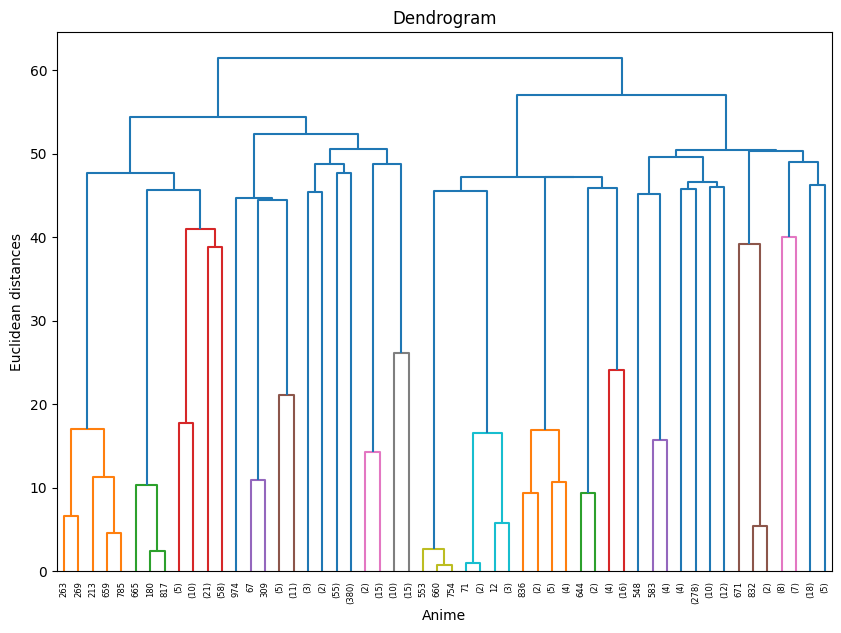

RMSE for Hierarchical Clustering: 0.8850345263509112
                                                     name  agg_cluster
144544                                   Myself; Yourself            1
638508  Campione!: Matsurowanu Kamigami to Kamigoroshi...            1
973380                                       Angel Beats!            0
676435                                   Vampire Hunter D            0
128970     Neon Genesis Evangelion: The End of Evangelion            0


In [28]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
anime_ratings = pd.read_csv('merged_anime_ratings.csv')

# Preprocess the data
anime_ratings['episodes'] = anime_ratings['episodes'].fillna(anime_ratings['episodes'].median())

# One-hot encode 'genre' and 'type' columns if they exist
if 'genre' in anime_ratings.columns:
    def encode_genres(df, column):
        genres_encoded = df[column].str.get_dummies(sep=',')
        return genres_encoded

    anime_ratings = pd.concat([anime_ratings.drop(columns=['genre']), encode_genres(anime_ratings, 'genre')], axis=1)

if 'type' in anime_ratings.columns:
    anime_ratings = pd.get_dummies(anime_ratings, columns=['type'])

# Assuming 'name' is the identifier and should not be scaled
X = anime_ratings.drop(columns=['name'])

# Sample the data
sample_size = 1000  # Adjust this size based on memory constraints
X_sample = X.sample(n=sample_size, random_state=42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Calculate the distance matrix for hierarchical clustering
linked = sch.linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, truncate_mode='level', p=5)
plt.title('Dendrogram')
plt.xlabel('Anime')
plt.ylabel('Euclidean distances')
plt.show()

# Apply Hierarchical Clustering
agg_cluster = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
anime_ratings_sample = anime_ratings.loc[X_sample.index]
anime_ratings_sample['agg_cluster'] = agg_cluster.fit_predict(X_scaled)

# Calculate RMSE for Hierarchical Clustering
def calculate_rmse(data, labels, n_clusters):
    centroids = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
    distances = np.sqrt(((data - centroids[labels]) ** 2).sum(axis=1))
    rmse = np.sqrt(mean_squared_error(data, centroids[labels]))
    return rmse

rmse_agg = calculate_rmse(X_scaled, anime_ratings_sample['agg_cluster'], 5)

print(f'RMSE for Hierarchical Clustering: {rmse_agg}')

# Display cluster assignments
print(anime_ratings_sample[['name', 'agg_cluster']].head())


**Analysis**

- The dendrogram in the image provides a visual representation of the hierarchical clustering of the anime rating data.
- Each leaf at the bottom of the dendrogram represents an individual anime, and as you move up, these anime are progressively merged into clusters based on similarities. The colors represent different clusters formed at specific levels of dissimilarity, and distances between clusters are shown on the y-axis.
-  By following the branches downwards from any cluster merge, you can see which anime are grouped together in that cluster. The dendrogram can help determine the optimal number of clusters.
- Analyzing the clusters can provide insights into the similarities between different anime, potentially based on features like ratings, genres, episodes, and types.




**Gaussian Mixture Model**

A Gaussian Mixture Model (GMM) is a probabilistic model used for clustering in which data points are modeled as a mixture of several Gaussian distributions.
- It's a powerful algorithm for discovering hidden patterns in data and assigning cluster membership probabilities to each point rather than hard assignments

                  name  cluster
0      High School DxD        3
1     Sword Art Online        3
2  High School DxD New        3
3     Kuroko no Basket        3
4               Naruto        3
RMSE for Gaussian Mixture Model Clustering: 0.9714386386059914


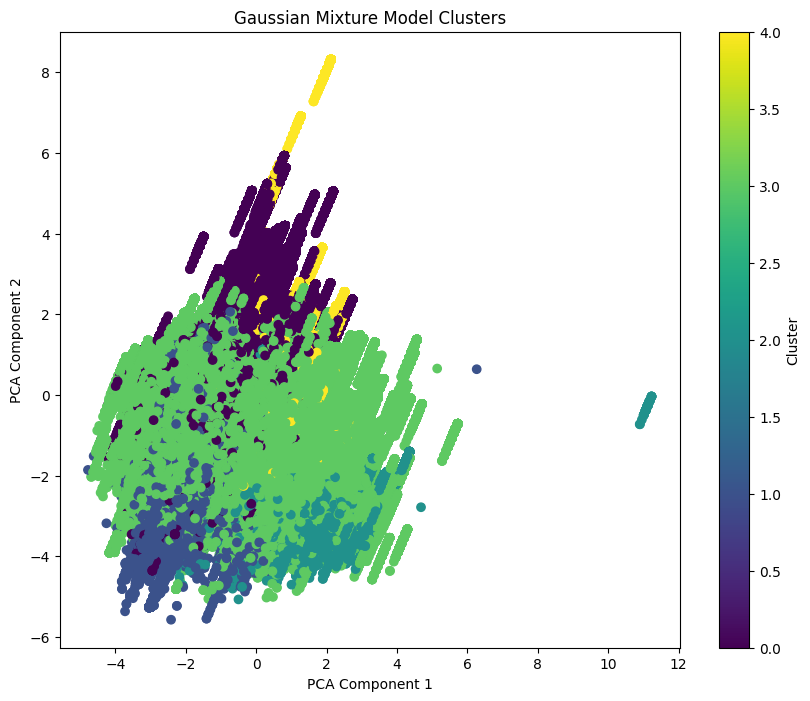

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the data
anime_ratings = pd.read_csv('merged_anime_ratings.csv')


# Preprocess the data
anime_ratings['episodes'] = anime_ratings['episodes'].fillna(anime_ratings['episodes'].median())

# One-hot encode 'genre' and 'type' columns if they exist
if 'genre' in anime_ratings.columns:
    def encode_genres(df, column):
        genres_encoded = df[column].str.get_dummies(sep=',')
        return genres_encoded

    anime_ratings = pd.concat([anime_ratings.drop(columns=['genre']), encode_genres(anime_ratings, 'genre')], axis=1)

if 'type' in anime_ratings.columns:
    anime_ratings = pd.get_dummies(anime_ratings, columns=['type'])

# Assuming 'name' is the identifier and should not be scaled
X = anime_ratings.drop(columns=['name'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)
anime_ratings['cluster'] = gmm.fit_predict(X_scaled)

# Display cluster assignments
print(anime_ratings[['name', 'cluster']].head())

# Calculate RMSE for Gaussian Mixture Model Clustering
def calculate_rmse(data, labels, centroids):
    distances = np.sqrt(((data - centroids[labels]) ** 2).sum(axis=1))
    rmse = np.sqrt(mean_squared_error(data, centroids[labels]))
    return rmse

# Get centroids from GMM
centroids = gmm.means_

# Calculate RMSE
rmse_gmm = calculate_rmse(X_scaled, anime_ratings['cluster'], centroids)
print(f'RMSE for Gaussian Mixture Model Clustering: {rmse_gmm}')

# Reduce dimensions with PCA (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the clusters using a scatter plot of the PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anime_ratings['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Gaussian Mixture Model Clusters')
plt.colorbar(label='Cluster')
plt.show()


***Evaluation and Intepretation***

Silhouette Score:

Measures how similar each data point is to its own cluster compared to other clusters.
- Higher scores indicate better-defined clusters.

## **Recommender Systems**

Recommender systems are algorithms and techniques used to predict and recommend items or content that users might be interested in. They are widely used in various industries, including e-commerce, streaming platforms, social media, and more.
- Building a recommender system for an anime dataset involves using various techniques to predict and suggest anime titles that users are likely to enjoy based on their preferences and behaviors.

<div align="center" style="font-size: 40%; text-align: center; margin: 0 auto">
    <img src="https://raw.githubusercontent.com/varian97/Anime-Recommender-System/master/image.png" style="display: block; margin-left: auto; margin-right: auto; width: 800px; height: 200px;" />
</div>


### **Collaborative Filtering**

- User-Based Collaborative Filtering: Recommends anime titles to a user based on the preferences of users who have similar tastes.
- Item-Based Collaborative Filtering: Recommends anime titles similar to those the user has liked or rated highly.

In [ ]:
# Import our regular old heroes
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficiency.
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convenient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [ ]:
anime_ratings = pd.read_csv('train_cleaned.csv')
anime_ratings.head()

 Normalize Ratings Using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame has columns 'user_id', 'anime_id', and 'rating'
scaler = MinMaxScaler()

# Normalize the 'rating' column to a range [0, 1]
anime_ratings['rating'] = scaler.fit_transform(anime_ratings[['rating']])

Create a User-Item Interaction Matrix:

Format your data into a matrix where rows represent users, columns represent items, and values represent ratings.

In [ ]:
# Example: Creating a user-item interaction matrix
user_item_matrix = anime_ratings.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)

Using scikit-surprise Library:

This library simplifies collaborative filtering with different algorithms.

In [ ]:
!pip install scikit-surprise

Build the Collaborative Filtering Model

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNBasic, SVD, SVDpp

# Define the data format
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(anime_ratings[['user_id', 'anime_id', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)


Choose a Collaborative Filtering Algorithm:

Matrix Factorization (SVD)

In [ ]:
from surprise import SVD

model_svd = SVD()
model_svd.fit(trainset)

Make Predictions with Collaborative Filtering

In [ ]:
predictions_svd = model_svd.test(testset)

# Evaluate the model
from surprise import accuracy

print(f"SVD RMSE: {accuracy.rmse(predictions_svd)}")

In [ ]:
test_data = pd.read_csv('test_cleaned.csv')
test_data.head()

In [ ]:
# Ensure the user_id and anime_id columns are in the correct data types
test_data['user_id'] = test_data['user_id'].astype(int)
test_data['anime_id'] = test_data['anime_id'].astype(int)

# Convert the test DataFrame to Surprise format
testset = [(row['user_id'], row['anime_id'], None) for index, row in test_data.iterrows()]

# Generate predictions
predictions_svd = model_svd.test(testset)

In [ ]:
# Extract relevant information from predictions
def extract_predictions(predictions):
    pred_list = []
    for uid, iid, true_r, est, _ in predictions:
        pred_list.append((uid, iid, est))
    return pred_list

df_predictions_svd = pd.DataFrame(extract_predictions(predictions_svd), columns=['user_id', 'anime_id', 'predicted_rating'])

# Create the 'ID' column
df_predictions_svd['ID'] = df_predictions_svd['user_id'].astype(str) + '_' + df_predictions_svd['anime_id'].astype(str)

# Assuming min_rating and max_rating were used during training
min_rating = scaler.data_min_[0]
max_rating = scaler.data_max_[0]

# Normalize the predictions back to the original scale
df_predictions_svd['rating'] = df_predictions_svd['predicted_rating'] * (max_rating - min_rating) + min_rating



In [ ]:
# Select only the required columns
submission_df = df_predictions_svd[['ID', 'rating']]

# Display the first few rows of the submission DataFrame
submission_df.head()


In [ ]:
# Save to CSV
submission_df.to_csv('svd_predictions_submission.csv', index=False)

Parameter Tuning

SVD Tuning

For SVD, you can tune parameters such as n_factors (number of latent factors), n_epochs (number of iterations), and lr_all (learning rate).

In [ ]:
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30, 50],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.4]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# Print the best score and the corresponding hyperparameters
print(f'Best RMSE: {gs.best_score["rmse"]}')
print(f'Best hyperparameters: {gs.best_params["rmse"]}')


In [ ]:
# Use the best model
best_model = gs.best_estimator['rmse']
best_model.fit(trainset)

# Generate predictions using the best model
predictions_svd = best_model.test(testset)

# Evaluate the model
print(f"SVD RMSE after tuning: {accuracy.rmse(predictions_svd)}")

### **Content Based Filtering**

In Content-based filtering, we seek to make recommendations based on **how similar an item's properties or features are to those of other items.**

So let's see how we would implement a system like this in real life.

In [ ]:
# Combine 'name' and 'genre' into a single string for each anime
anime['name_genre'] = (pd.Series(anime[['name', 'genre']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

# Convenient indexes to map between anime titles and indexes of the merged_df dataframe
titles = anime['name']
indices = pd.Series(anime.index, index=anime['name'])


We now need a mechanism to convert these textual features into a format that enables us to compute their relative similarities. This will allow us to translate our string-based collection of tags and authors into numerical vectors (see [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for an overview of this process which is very similar to [count-based vectorization](https://youtu.be/W9VtEVBdgnQ)).

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to an anime,
# with TF-IDF features as columns
tf_namgen_matrix = tf.fit_transform(anime['name_genre'])

We can now compute the similarity between each vector within our matrix. This is done by making use of the `cosine_similarity` function provided to us by `sklearn`.

In [ ]:
cosine_sim_namgen = cosine_similarity(tf_namgen_matrix,
                                        tf_namgen_matrix)
print (cosine_sim_namgen.shape)

In [ ]:
cosine_sim_namgen[:5]

#### Top-N recommendations

With our content similarity matrix computed, we're now ready to make some recommendations! Let's begin by generating a top-N list of animes similar to the one which we prompt the system with.    

Following along from our earlier algorithmic explanation, we do this by:

  1. Select an initial item (anime) from which to generate recommendations.
  2. Extract all the similarity values between the initial item and each other item in the similarity matrix.
  3. Sort the resulting values in descending order.
  4. Select the top N similarity values and return the corresponding item details to the user. This is now our simple top-N list.  
  
We implement this algorithmic process in the function below:

In [ ]:
def content_generate_top_N_recommendations(anime_title, N=10):
    # Convert the string anime title to a numeric index for our similarity matrix
    a_idx = indices[anime_title]

    # Extract all similarity values computed with the reference anime title
    sim_scores = list(enumerate(cosine_sim_namgen[a_idx]))

    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N+1]  # Include N recommendations

    # Collect indexes
    anime_indices = [i[0] for i in sim_scores]

    # Convert the indexes back into titles
    return titles.iloc[anime_indices]



In [ ]:
# Example usage
recommended_animes = content_generate_top_N_recommendations('Shingeki no Kyojin', N=10)
print(recommended_animes)

With our function defined, let's test our simple content-based recommender on some sample anime titles:

In [ ]:
content_generate_top_N_recommendations("Fullmetal Alchemist: Brotherhood", N=10)

---
#### Rating Prediction

As motivated previously, in some cases, we may wish to calculate directly what rating a user _would_ give a book that they haven't read yet.
We implement this algorithmic process in the function below:

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Define the reader with the rating scale
reader = Reader(rating_scale=(anime_ratings['rating'].min(), anime_ratings['rating'].max()))

# Load the data into the Surprise dataset
data = Dataset.load_from_df(anime_ratings[['user_id', 'anime_id', 'rating']], reader)

# Split the data into training and test sets
trainset, _ = train_test_split(data, test_size=0.25, random_state=42)

# Define the SVD model
model = SVD()

# Train the model
model.fit(trainset)


In [ ]:
# Load your dataset
test_data = pd.read_csv('test_cleaned.csv')

In [ ]:
test_data.shape

In [ ]:
# Function to predict ratings for test data
def generate_submission(test_data, model):
    predictions = []
    for row in test_data.itertuples(index=False):
        user_id, anime_id = row.user_id, row.anime_id
        pred = model.predict(user_id, anime_id).est
        predictions.append((f"{user_id}_{anime_id}", pred))

    # Create the submission DataFrame
    submission = pd.DataFrame(predictions, columns=['ID', 'rating'])
    # Ensure the number of rows matches the test set
    assert len(submission) == len(test_data), f"Submission must have {len(test_data)} rows, but has {len(submission)} rows."

    return submission



In [ ]:
# Generate predictions for the test data
submission = generate_submission(test_data, model)

In [ ]:
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")


In [ ]:
submission.shape

In [ ]:
submission.head()

With our algorithm defined, let's quickly test it out to see some results.

To help us get a sense of the relevance and accuracy of these ratings, we select a lucky user (number 150) and consider their historical data:

In [ ]:
# Subset of ratings from user 150
anime_ratings[anime_ratings['user_id'] == 150][3:10]

### **Conclusions and Insights**